# Suggestion Detection

---

This work involves feature engineering, training and evaluating a classifier for suggestion detection, using the data from SemEval-2019 Task 9 subtask A to classify whether a piece of text contains a suggestion or not. 

The CSV file contains a header row followed by 6,100 rows spread across 3 columns of data. Each row of data contains a unique id, a piece of text and a label assigned by an annotator. A label of $1$ indicates that the given text contains a suggestion while a label of $0$ indicates that the text does not contain a suggestion.

You can find more details about the dataset in Sections 1, 2, 3 and 4 of [SemEval-2019 Task 9: Suggestion Mining from Online Reviews and Forums
](https://aclanthology.org/S19-2151/).


---

## Reading Data

The following cell of code reads the texts and the corresponding labels of suggestion/non-suggestion from the CSV file. The first task is to create training and test sets. Use the final $1000$ rows of the data as a test set and the rest of the data for training.

In [2]:
# function to divide text and labels of any data sent as list
def divide_text_labels(data_list):
    texts, labels = [], []
    for data_text, data_label in data_list:
        texts.append(data_text)
        labels.append(data_label)
    return texts, labels

In [3]:
import numpy as np
import pandas as pd

# Read the CSV file.
df = pd.read_csv('Data.Assignment2.SemEvalTask9SubtaskA.csv', 
                 names=['id', 'text', 'label'], header=0)

# Set seed for reproducibility and shuffle the rows.
np.random.seed(888)
df = df.sample(frac=1).reset_index(drop=True)

# Store the data as a list of tuples where the first item is the text
# and the second item is the label.
data = [(text, label) for (idx, text, label) in df.values.tolist()]

# Create training and test sets.
train_texts, train_labels = [], []
test_texts, test_labels = [], []

# adding last 1000 rows in test and remaining in train
train_texts, train_labels = divide_text_labels(data[:-1000])
test_texts, test_labels = divide_text_labels(data[-1000:])

#assert len(test_texts) == len(test_labels) == 1000
#assert len(train_texts) == len(train_labels) == 5100

In [4]:
# \n or \r\n present in text
print("\\n present in: ", len(df[df["text"].map(lambda x: "\n" in x)==True]))
print("\\r\\n present in: ", len(df[df["text"].map(lambda x: "\r\n" in x)==True]))

\n present in:  117
\r\n present in:  117


---

## Task 2: Data Pre-processing

Edit this cell to write your answer below the line in no more than 300 words.

---
>  We can consider the following pre-processing steps in order:
> 1. Converting the text to lowercase, so that case sensitivity doesn't play role in defining words. For e.g. Advice and advice are considered same.

> 2. It can be seen that \r\n is present in the sentences (shown in above cell), which doesn't contribute to the decision of identification of a suggestion. These instances of \r\n can be replaced by a whitespace.

> 3. Replacing the punctuations and special characters with whitespaces, as it can cause same words to be counted multiple times. For e.g., "hence" and "hence," or "add", "remove", and "add/remove". Not performin this step can cause such redundancy to interfere with the vocabulary and term weighting scheme.

> 4. Above steps can lead to multiple unnecessary spaces in the text. Multiple spaces can be replaced with a single space, for e.g. "hence, this works" will become "hence  this works" with an extra space between "hence" and "this".

> 5. Once above steps are performed, there can be leading and trailing spaces in text (for e.g., if the fullstop at the end is replaced with a whitespace), which can be removed.

> 6. Stopwords <b>can be or cannot be</b> removed depending on whether they help in suggestion identification. Same is the case with Stemming, i.e. <b>it might or might not help.</b> We will proceed without performing these steps for now, but will perform and analyse the effect of both of these preprocessing steps after Task 4 (after defining an alternative metric to accuracy) as this metric will be used to access.
---

In the code cell below, write an implementation of the steps you defined above. You are free to use a library such as `nltk` or `sklearn` for this task.

In [5]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# filtering stopwords
def filter_stopwords(text):
    filtered_word_list = []
    for word in text.split():
        if word not in stopwords.words('english'):
            filtered_word_list.append(word)
    return " ".join(filtered_word_list)

def stem_words(text, stemmer):
    stemmed_word_list = []
    for word in text.split():
        stemmed_word_list.append(stemmer.stem(word))
    return " ".join(stemmed_word_list)

def pre_process(data_text_list, combination = (False, False)):
    # converting data to lowercase
    data_text_list = [data_text.lower() for data_text in data_text_list]
    # removing newlines
    data_text_list = map(lambda x: x.replace("\r\n", " "), data_text_list)
    
    # replacing punctuations and special chars with whitespaces
    pattern = f"[{string.punctuation}]+"
    data_text_list = map(lambda x: re.sub(pattern, " ", x), data_text_list)
    
    # unneccessary and trailing/leading spaces can be removed by using join
    data_text_list = list(map(lambda x: " ".join(x.split()), data_text_list))
    
    # filtering stopwords and stemmingbased on condition
    if combination[0]:
        data_text_list = list(map(filter_stopwords, data_text_list))
    if combination[1]:
        stemmer = PorterStemmer()
        data_text_list = [stem_words(text, stemmer) for text in data_text_list]
    return data_text_list 

In [6]:
# train and test data with stopword_removal = 0 and stemming = 0
# i.e. without performing the above steps
train_stop_0_stem_0 = pre_process(train_texts)
test_stop_0_stem_0 = pre_process(test_texts)

---
## Task 3: Feature Engineering (I)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB

# Calculate tf-idf scores for the words in the training set.
# ... your code goes here

# Predict on the test set.
predictions = []    # save your predictions on the test set into this list

# generating word counts and tfidf for training set and model training
def train_model(train_data, test_data):
    global predictions
    predictions = []
    
    # generating tf_idf using countVectorizer and tfidf_transformer
    cv = CountVectorizer()
    tf_idf_trans = TfidfTransformer()
    train_word_counts = cv.fit_transform(train_data)
    train_tf_idf_vals = tf_idf_trans.fit_transform(train_word_counts)

    # Train a Naïve Bayes classifier using the tf-idf scores for words as features.
    # ... your code goes here
    nb_model = GaussianNB()
    nb_model.fit(train_tf_idf_vals.toarray(), np.array(train_labels))

    # ... your code goes here
    # generating features for test-set
    test_word_counts = cv.transform(test_data)
    test_tf_idf_vals = tf_idf_trans.transform(test_word_counts)

    for result in nb_model.predict(test_tf_idf_vals.toarray()):
        predictions.append(result)

# running training and evaluation for the dataset with no stopword removal and no stemming
train_model(train_stop_0_stem_0, test_stop_0_stem_0)

0.557

---

## Task 4: Evaluation Metric


---

> Accuracy is not a very good evaluation measure for classification due to the presence of skewness in class distributions which is very frequent in datasets. As can also be seen in our training dataset or overall dataset as well, the number of negatives is much high in quantity. In such cases, just predicting a single class without any training can give good accuracy number.

> Instead, F1 score can be used as a metric which is defined as the harmonic mean of precision and recall.
> where,
> precision = True Positives / (True Positives + False Positives)
> recall = True Positives / (True Positives + False Negatives)
> Using F1 takes a balanced approach, defining a metric that considers the effects of false postives (wrong classifications) and negatives (positives in data which weren't identified).

---

In the code cell below, write an implementation of the evaluation metric you defined above. You are free to use a library such as `nltk` or `sklearn` for this task, or you can write your own implementation from scratch.

In [ ]:
def evaluate(labels, predictions):
    # check that labels and predictions are of same length
    assert len(labels) == len(predictions)

    score = 0.0

    #################### EDIT BELOW THIS LINE #########################

    # your code goes here
    # implementation of F1 score
    tp, fp, fn = 0, 0, 0  # variables to store true_positive, false_positive, false_negative respectively
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            if label == 1:
                tp += 1
        else:
            if label == 1:
                fn += 1
            else:
                fp += 1
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    score = round(2 * precision * recall / (precision + recall), 2)
    
    #printing the precision, recall and F1 metrics
    print(f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, F1: {score}")
    #################### EDIT ABOVE THIS LINE #########################

    return score

# for the classifier trained in Task 3 using tf-idf features.
evaluate(test_labels, predictions)

To access the effect of stemming and stopwords, we will use the above defined metric in Task 4
we can create four pairs of datasets based on removal_stopwords = {Yes, No} and stemming = {Yes, No} 
and print the results

In [9]:
#--------------Running this cell might take 1-2 mins due to stemming and stopword removal ---------------##########

# using itertools to generate 4 combinations of two boolean variables
import itertools
for combination in itertools.product([True, False], repeat = 2):
    name_train_data = f"pro_train_stop_{int(combination[0])}_stem_{int(combination[1])}"
    name_test_data = f"pro_test_stop_{int(combination[0])}_stem_{int(combination[1])}"
    
    # preprocessing train and test data with the generated combination
    exec(f"{name_train_data} = pre_process(train_texts, combination)")
    exec(f"{name_test_data} = pre_process(test_texts, combination)")
    
    # training the model and printing the metrics
    train_model(eval(f"{name_train_data}"), eval(f"{name_test_data}"))
    print(f"For stopword_removal = {combination[0]}, stemming = {combination[1]}:", evaluate(test_labels, predictions))

Precision: 0.4, Recall: 0.76, F1: 0.52
For stopword_removal = True, stemming = True: 0.52
Precision: 0.42, Recall: 0.68, F1: 0.52
For stopword_removal = True, stemming = False: 0.52
Precision: 0.4, Recall: 0.77, F1: 0.53
For stopword_removal = False, stemming = True: 0.53
Precision: 0.42, Recall: 0.68, F1: 0.52
For stopword_removal = False, stemming = False: 0.52


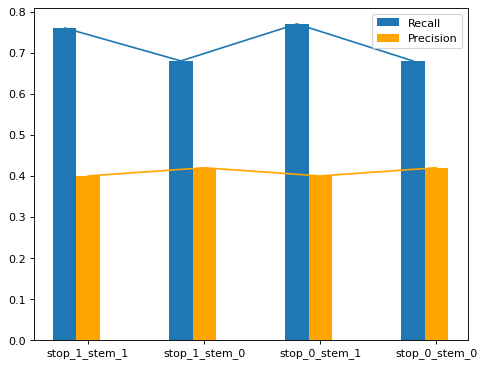

In [10]:
# plotting the above results
import matplotlib.pyplot as plt
# putting the values in dataframe for the plot
results_df = pd.DataFrame(columns = ["Conf.", "Precision", "Recall", "F1"],
                         data = [["stop_1_stem_1", 0.4, 0.76, 0.52], 
                                 ["stop_1_stem_0", 0.42, 0.68, 0.52], 
                                 ["stop_0_stem_1", 0.4, 0.77, 0.53], 
                                 ["stop_0_stem_0", 0.42, 0.68, 0.52]])

plt.figure(figsize=(7, 5.5), dpi=80)
axis = np.arange(4)
plt.bar(x = axis - 0.2, height = results_df["Recall"], width = 0.2)
plt.bar(height = results_df["Precision"], x = axis, width = 0.2, color = "orange")
plt.xticks(axis, results_df["Conf."])
plt.legend(("Recall", "Precision"))
plt.plot(results_df["Precision"], color = "orange")
plt.plot(axis - 0.2, results_df["Recall"])

Although the overall precision is similar, it can be seen that stemming offers significant advantage in recall (stem = 1 bars have more recall than its counterpart). For the improvement in Task 5, we can include stemming. On the other hand, stopword removal doesn't seem to influence the performance of our classifier (stop = 1 or 0 has more or less same performance) and hence it can be ignored.

---

## Task 5: Feature Engineering (II)

---
>In addition to the preprocessing steps defined above,
> 1. It is shown in the above analysis how stopword removal doesn't help here, but we can consider the frequency distribution of words for removing the hapaxes, i.e. the words occuring only once as they might not offer insights about identification, these also include the words that are mistyped. 

> 2. We can also take syntactic information like POS tagging as a feature, since there can be several parts of speech that are more probable to be suggestions. To combine POS information along with the word, we will consider unigrams, bigrams and trigrams of POS as well.

> 3. In the above model, we only took the unigrams into consideration. Here, we can also consider bigrams and trigrams as they can offer significant information. Many pairs of words might be potentially present in suggestions. For e.g. common phrases used by people like "Please advise ...".

> 4. One of the potential feature could be the number of tokens present in the text. The intuition behind this being that the number of tokens (length of text) might influence suggestion identification. However, on plotting the distribution for the label = 0 and label = 1, we see that the distributions are similar and there is no reliable dependency on number on tokens.

> 5. In the above task, we tried Gaussian Naive Bayes model, but since Multinomial is known to work very well in cases of discrete features (e.g. frequencies of words), it can also be tried as it works with TfIdf as well and can supercede the Gaussian Naive bayes performance. 

>After working on the above features, we get a significant improvement in F1 score as well as precisionand recall. The F1 at the end of task 3 was 0.51, while after adding the above defined features gives us significant improvement (F1 = 0.67). Furthermore, for the given dataset it turns out that ensemble of both these Naive Bayes types works better than any one. Combination of two variants of Naive Bayes models (Gaussian and Multinomial) gives us an F1 = 0.75. The implementation and analysis is shown below.

---

In [42]:
# we will be using the df obtained after reading the data and sampling 
data_df = df.drop(columns = ["id"])

# dividing into train and test
train_df, test_df = data_df[0:-1000], data_df[-1000:]
# passing combination parameter for remove_stopword = False, and stem = false
train_df["text"] = pre_process(list(train_df["text"]), combination = (False, False))

<ipython-input-42-82ba01bc8806>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["text"] = pre_process(list(train_df["text"]), combination = (False, False))


<ipython-input-61-6bb67b029dac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["num_tokens"] = train_df["text"].map(lambda x: len(x.split()))


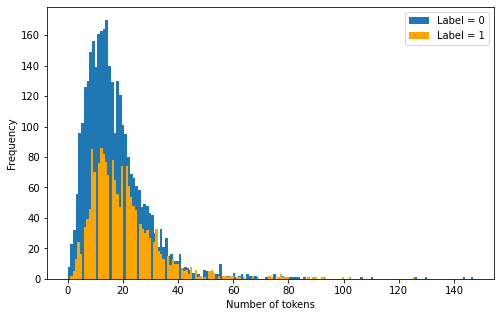

In [61]:
"""
one of the potential feature could have been the number of tokens present in the text. However, on plotting the 
distribution for the label = 0 and label = 1, we see that the distributions are similar and don't depend on number on tokens.
"""
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 5))
train_df["num_tokens"] = train_df["text"].map(lambda x: len(x.split()))
train_df[train_df["label"] == 0]["num_tokens"].plot.hist(by = "num_tokens", bins = 150, label = "Label = 0")
x = plt.hist(x = train_df[train_df["label"] == 1]["num_tokens"], bins = 150, color = "orange", label = "Label = 1")
plt.legend()
label = plt.xlabel("Number of tokens")

In [44]:
# Create your features.
# ... your code goes here

from nltk import FreqDist
from nltk import pos_tag
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# using frequency distribution to remove hapaxes
freq_dist = FreqDist(word for record in list(train_df["text"]) for word in record.split())
# defining the words to keep after removing the hapaxes
words_to_keep = set(list(freq_dist.most_common(len(freq_dist)-len(freq_dist.hapaxes()))))
words_to_keep = [word[0] for word in words_to_keep]

# filter the words using the variable words_to_keep
def filter_words_to_keep(text):
    filtered_sent = []
    for word in text.split():
        if word in words_to_keep: filtered_sent.append(word)
    return " ".join(filtered_sent)

def additional_processing_steps(dataset):
    # filtering the words from the dataset
    dataset["text"] = dataset["text"].map(filter_words_to_keep)

    # considering part-of-speech tags
    dataset["postags"] = dataset["text"].map(lambda text: pos_tag(text.split()))
    dataset["postags"] = dataset["postags"].map(lambda x: " ".join([tag[1] for tag in x]))

    # adding postags as new words
    dataset["word_postag"] = dataset.apply(lambda x: x["text"] + " " + x["postags"], axis = 1)
    
    return dataset
    
train_df = additional_processing_steps(train_df)
# considering the unigrams, bigrams and trigrams in countvectorizer
count_vec = CountVectorizer(ngram_range = (1, 2))
tf_idf = TfidfTransformer()

train_counts = count_vec.fit_transform(list(train_df["word_postag"]))
train_tfidf = tf_idf.fit_transform(train_counts)

<ipython-input-44-d74893fb7d95>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["text"] = dataset["text"].map(filter_words_to_keep)
<ipython-input-44-d74893fb7d95>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["postags"] = dataset["text"].map(lambda text: pos_tag(text.split()))
<ipython-input-44-d74893fb7d95>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [46]:

##--Running this cell might take around 3 minutes and upto 12GB RAM to run due to grid search, while occupying 4 cores of CPU ###

# Train a Naïve Bayes classifier using the features you defined.
# ... your code goes here
# creating the instances of multinomial and gaussian
nb_model_Mul = MultinomialNB()
nb_model_Gau = GaussianNB()

# using grid search with 5 fold cross validation to tune the hyperparameters provided by the models 
# (smoothing for Gaussian NB and alpha for Multinomial)

params_NB = {'var_smoothing': np.logspace(0,-9, num = 4)}
params_Mul = {'alpha': np.logspace(0,1,num = 4)}

########### Following piece of code takes around 3 minutes and around 10 GB RAM to run the GridSearch
# defining Gaussian grid search instance
grid_search_Gau = GridSearchCV(estimator = nb_model_Gau, 
                 param_grid = params_NB,
                 verbose = 1, 
                 scoring = "f1", n_jobs = 4) 
# defining Multinomial grid search instance
grid_search_Mul = GridSearchCV(estimator = nb_model_Mul, 
                 param_grid = params_Mul,
                 verbose = 1, 
                 scoring = "f1", n_jobs = 4)

# fitting the models after finding the correct parameters
grid_search_Gau.fit(train_tfidf.toarray(), np.array(list(train_df["label"])))
grid_search_Mul.fit(train_tfidf.toarray(), np.array(list(train_df["label"])))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.4min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   21.1s finished


GridSearchCV(estimator=MultinomialNB(), n_jobs=4,
             param_grid={'alpha': array([ 1.        ,  2.15443469,  4.64158883, 10.        ])},
             scoring='f1', verbose=1)

In [47]:
# Evaluate on the test set.
# ... your code goes here

# replicating all preprocessing steps on test set
test_df["text"] = pre_process(list(test_df["text"]), combination = (False, False))
test_df = additional_processing_steps(test_df)
test_counts = count_vec.transform(list(test_df["word_postag"]))
test_tfidf = tf_idf.transform(test_counts)

# getting predictions for the supplied model
def get_predictions(fitted_model):
    predictions = []
    for result in fitted_model.predict(test_tfidf.toarray()):
        predictions.append(result)
    return predictions

# evaluating the Gaussian Naive Bayes
print("For Gaussian Naive bayes: ")
predictions = get_predictions(grid_search_Gau)
score = evaluate(list(test_df["label"]), predictions)
# evaluating the Multinomial Naive Bayes
print("For Multinomial Naive bayes: ")
predictions = get_predictions(grid_search_Mul)
score = evaluate(list(test_df["label"]), predictions)

<ipython-input-47-b7266c355b63>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["text"] = pre_process(list(test_df["text"]), combination = (False, False))
<ipython-input-44-d74893fb7d95>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["text"] = dataset["text"].map(filter_words_to_keep)
<ipython-input-44-d74893fb7d95>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

For Gaussian Naive bayes: 
Precision: 0.52, Recall: 0.95, F1: 0.67
For Multinomial Naive bayes: 
Precision: 0.93, Recall: 0.15, F1: 0.26


It can be seen how different models show different properties, <br> - Gaussian NB gives high recall and descent precision.<br> - Multinomial NB gives extremely high precision with very low recall. <br>We can take the probabilities and combine them (using weighted average) to trade off and get an overall better F1.

Precision: 0.77, Recall: 0.68, F1: 0.72
Precision: 0.71, Recall: 0.78, F1: 0.75
Precision: 0.66, Recall: 0.84, F1: 0.73
Precision: 0.61, Recall: 0.88, F1: 0.72
Precision: 0.57, Recall: 0.92, F1: 0.7
Precision: 0.55, Recall: 0.93, F1: 0.69
Precision: 0.52, Recall: 0.95, F1: 0.67


Text(0, 0.5, 'F1 score')

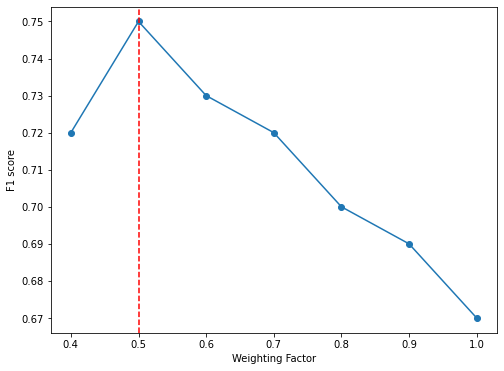

In [51]:
# resolving the predictions from class probabilites
def get_predictions_from_prob(pred_prob):
    predictions = []
    for i in pred_prob:
        if i[0] > i[1]:
            predictions.append(0)
        else: predictions.append(1)
    return predictions

# storing the weighting factor and corresponding F1 metric
f1_scores_vals = []

# trying out different weighting factors, 
# starting from 0.4 for the Gaussian Model, as it shows overall better results (F1: 0.67 with extremely high recall)
# as compared to Multinomial (F1: 0.26 with extremely high precision) 
for val in np.linspace(0.4, 1, 7):
    # defining probability as a weighted average
    pred_prob = val * grid_search_Gau.predict_log_proba(test_tfidf.toarray()) + (1-val) * grid_search_Mul.predict_log_proba(test_tfidf.toarray())
    # resolving the probabilities to predictions
    predictions = get_predictions_from_prob(pred_prob)
    # evaluating the predictions on defined F1 metric
    res = evaluate(list(test_df["label"]), predictions)
    f1_scores_vals.append((val, res))
    
# taking the max_f1 value and corresponding weighting factor
max_f1 = max(f1_scores_vals, key = lambda x: x[1])

# plotting the variations in F1
plt.figure(figsize = (8, 6))
weighting_values = [pair[0] for pair in f1_scores_vals]
f1_scores = [pair[1] for pair in f1_scores_vals]
plt.plot(weighting_values, f1_scores, marker = "o")
plt.axvline(x = max_f1[0], color = "r", linestyle = "dashed")
plt.xlabel("Weighting Factor"); plt.ylabel("F1 score")

For the given dataset, we get the maximum F1 of 0.75 at weight value = 0.5 for both (i.e. average of both the probabilities) of Gaussian and Multinomial Naive bayes probabilities. Hence, the average of probabilities/log probabilities from both trained models can be used for predictions.